In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import time
import string
import warnings

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# To consume Twitter's API
import tweepy
from tweepy import OAuthHandler 

# To identify the sentiment of text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor

# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

# for showing all the plots inline
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\khura\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\khura\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\khura\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\khura\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\khura\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\khura\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is alr

In [34]:
class TwitterClient(object): 
    def __init__(self): 
        #Initialization method. 
        try: 
            # create OAuthHandler object 
            auth = OAuthHandler('MWagHIMZgBCE8ExJw4ZEhBeqd', 'pHoXxG9mXVDlLInne7xajFJ8WdyPKhuXdAwJOnYu9qUOT0Go8U') 
            # set access token and secret 
            auth.set_access_token('18837312-7UAgD8xarB9RgUKv263ftqGKnYkSIHAgjzVvf7K1f', 'pjc3MOSDmCXz3mAFt28gfjWdQqNVqcSUzA4BhVChNFQqP') 
            # create tweepy API object to fetch tweets 
            # add hyper parameter 'proxy' if executing from behind proxy "proxy='http://172.22.218.218:8085'"
            self.api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
            
        except tweepy.TweepError as e:
            print(f"Error: Twitter Authentication Failed - \n{str(e)}")

    def get_tweets(self, query, maxTweets = 1000):
        #Function to fetch tweets. 
        # empty list to store parsed tweets 
        tweets = [] 
        sinceId = None
        max_id = -1
        tweetCount = 0
        tweetsPerQry = 100

        while tweetCount < maxTweets:
            try:
                if (max_id <= 0):
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, geo = '43.651070,-79.347015,250km', lang='en', count=tweetsPerQry)
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,geo = '43.651070,-79.347015,250km', lang='en',
                                                since_id=sinceId)
                else:
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,geo = '43.651070,-79.347015,250km', lang='en',
                                                max_id=str(max_id - 1))
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,geo = '43.651070,-79.347015,250km', lang='en',
                                                max_id=str(max_id - 1),
                                                since_id=sinceId)
                if not new_tweets:
                    print("No more tweets found")
                    break

                for tweet in new_tweets:
                    parsed_tweet = {} 
                    parsed_tweet['tweets'] = tweet.text 

                    # appending parsed tweet to tweets list 
                    if tweet.retweet_count > 0: 
                        # if tweet has retweets, ensure that it is appended only once 
                        if parsed_tweet not in tweets: 
                            tweets.append(parsed_tweet) 
                    else: 
                        tweets.append(parsed_tweet) 
                        
                tweetCount += len(new_tweets)
                print("Downloaded {0} tweets".format(tweetCount))
                max_id = new_tweets[-1].id

            except tweepy.TweepError as e:
                # Just exit if any error
                print("Tweepy error : " + str(e))
                break
        
        return pd.DataFrame(tweets)

In [35]:
twitter_client = TwitterClient()

# calling function to get tweets
tweets_df = twitter_client.get_tweets('HSBC', maxTweets=7000)
print(f'tweets_df Shape - {tweets_df.shape}')
# tweets_df.head(10)
# len(tweets_df)

Downloaded 66 tweets
Downloaded 138 tweets
Downloaded 230 tweets
Downloaded 326 tweets
Downloaded 425 tweets
Downloaded 524 tweets
Downloaded 603 tweets
Downloaded 701 tweets
Downloaded 795 tweets
Downloaded 883 tweets
Downloaded 973 tweets
Downloaded 1061 tweets
Downloaded 1153 tweets
Downloaded 1229 tweets
Downloaded 1310 tweets
Downloaded 1391 tweets
Downloaded 1469 tweets
Downloaded 1541 tweets
Downloaded 1608 tweets
Downloaded 1686 tweets
Downloaded 1752 tweets
Downloaded 1846 tweets
Downloaded 1938 tweets
Downloaded 2015 tweets
Downloaded 2098 tweets
Downloaded 2185 tweets
Downloaded 2265 tweets
Downloaded 2354 tweets
Downloaded 2436 tweets
Downloaded 2517 tweets
Downloaded 2611 tweets
Downloaded 2687 tweets
Downloaded 2752 tweets
Downloaded 2834 tweets
Downloaded 2896 tweets
Downloaded 2965 tweets
Downloaded 3033 tweets
Downloaded 3093 tweets
Downloaded 3154 tweets
Downloaded 3215 tweets
Downloaded 3268 tweets
Downloaded 3343 tweets
Downloaded 3407 tweets
Downloaded 3458 tweets


In [51]:
tweets_df

,tweets,sentiment,tidy_tweets
0,RT @ipacglobal: The Telegraph: Senior staff at...,pos,"The Telegraph: Senior staff at HSBC, Standard..."
1,@HSBC had a cheque that I need to pay in for l...,pos,@HSBC had a cheque that I need to pay in for l...
2,RT @smitaprakash: Leaked files expose mass inf...,neg,Leaked files expose mass infiltration of UK f...
3,RT @BenGartside: Scoop with @JackHHazlewood an...,pos,Scoop with @JackHHazlewood and Senior staff a...
4,RT @stopadani: “There’s no long-term growth pr...,pos,“There’s no long-term growth prospect at all ...
...,...,...,...
1242,@MeghUpdates I heard HSBC had blocked account ...,neg,@MeghUpdates I heard HSBC had blocked account ...
1243,@afneil The HSBC Office is relatively close to...,pos,@afneil The HSBC Office is relatively close to...
1244,"@HSBC_UK Hi, thanks for your reply. I just sen...",pos,"@HSBC_UK Hi, thanks for your reply. I just sen..."
1245,Leaked files expose mass infiltration of UK fi...,neg,Leaked files expose mass infiltration of UK fi...


In [37]:
# Sentiment classification for above tweets

# 1 way
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

# 2 way
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

In [38]:
# Using NLTK's SentimentIntensityAnalyzer
sentiments_using_SIA = tweets_df.tweets.apply(lambda tweet: fetch_sentiment_using_SIA(tweet))
pd.DataFrame(sentiments_using_SIA.value_counts())

,tweets
pos,830
neg,417


In [40]:
# Using TextBlob
sentiments_using_textblob = tweets_df.tweets.apply(lambda tweet: fetch_sentiment_using_textblob(tweet))
pd.DataFrame(sentiments_using_textblob.value_counts())

,tweets
pos,1083
neg,164


In [50]:
# higher negative classification by SIA so using that
tweets_df['sentiment'] = sentiments_using_SIA
tweets_df.head()

,tweets,sentiment,tidy_tweets
0,RT @ipacglobal: The Telegraph: Senior staff at...,pos,"The Telegraph: Senior staff at HSBC, Standard..."
1,@HSBC had a cheque that I need to pay in for l...,pos,@HSBC had a cheque that I need to pay in for l...
2,RT @smitaprakash: Leaked files expose mass inf...,neg,Leaked files expose mass infiltration of UK f...
3,RT @BenGartside: Scoop with @JackHHazlewood an...,pos,Scoop with @JackHHazlewood and Senior staff a...
4,RT @stopadani: “There’s no long-term growth pr...,pos,“There’s no long-term growth prospect at all ...


In [48]:
# Pre-processing - cleaning up tweets

# remove handles

def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text 

In [70]:
tweets_df['tidy_tweets'] = np.vectorize(remove_pattern)(tweets_df['tweets'], "@[\w]* | *RT* | *@[\w]*:")
tweets_df.head(50)

,tweets,sentiment,tidy_tweets
0,RT @ipacglobal: The Telegraph: Senior staff at...,pos,"The Telegraph: Senior staff at HSBC, Standard..."
1,@HSBC had a cheque that I need to pay in for l...,pos,had a cheque that I need to pay in for like 2 ...
2,RT @smitaprakash: Leaked files expose mass inf...,neg,Leaked files expose mass infiltration of UK f...
3,RT @BenGartside: Scoop with @JackHHazlewood an...,pos,"Scoop with and Senior staff at HSBC, Standard..."
4,RT @stopadani: “There’s no long-term growth pr...,pos,“There’s no long-term growth prospect at all ...
5,RT @benedictrogers: HSBC should reveal its han...,pos,"HSBC should reveal its hand on Hong Kong, war..."
6,RT @ipacglobal: Full story:\n\nLeaked files ex...,neg,Full story:\n\nLeaked files expose mass infil...
7,RT @d1gitalflow: Leaked database of 1.95millio...,pos,Leaked database of 1.95million members from C...
8,@stuyoso Hi there - Thanks for spreading aware...,pos,Hi there - Thanks for spreading awareness. ⚠️ ...
9,RT @benedictrogers: This may be part of the ex...,neg,This may be part of the explanation for why t...


In [72]:
#removing links

cleaned_tweets = []

for index, row in tweets_df.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.tidy_tweets.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweets_df['tidy_tweets'] = cleaned_tweets
tweets_df.head(10)

,tweets,sentiment,tidy_tweets
0,RT @ipacglobal: The Telegraph: Senior staff at...,pos,"The Telegraph: Senior staff at HSBC, Standard ..."
1,@HSBC had a cheque that I need to pay in for l...,pos,had a cheque that I need to pay in for like 2 ...
2,RT @smitaprakash: Leaked files expose mass inf...,neg,Leaked files expose mass infiltration of UK fi...
3,RT @BenGartside: Scoop with @JackHHazlewood an...,pos,"Scoop with and Senior staff at HSBC, Standard ..."
4,RT @stopadani: “There’s no long-term growth pr...,pos,“There’s no long-term growth prospect at all f...
5,RT @benedictrogers: HSBC should reveal its han...,pos,"HSBC should reveal its hand on Hong Kong, warn..."
6,RT @ipacglobal: Full story:\n\nLeaked files ex...,neg,Full story: Leaked files expose mass infiltrat...
7,RT @d1gitalflow: Leaked database of 1.95millio...,pos,Leaked database of 1.95million members from Ch...
8,@stuyoso Hi there - Thanks for spreading aware...,pos,Hi there - Thanks for spreading awareness. ⚠️ ...
9,RT @benedictrogers: This may be part of the ex...,neg,This may be part of the explanation for why th...


In [73]:
#remove empty tweets
tweets_df = tweets_df[tweets_df['tidy_tweets']!='']
tweets_df.head()

,tweets,sentiment,tidy_tweets
0,RT @ipacglobal: The Telegraph: Senior staff at...,pos,"The Telegraph: Senior staff at HSBC, Standard ..."
1,@HSBC had a cheque that I need to pay in for l...,pos,had a cheque that I need to pay in for like 2 ...
2,RT @smitaprakash: Leaked files expose mass inf...,neg,Leaked files expose mass infiltration of UK fi...
3,RT @BenGartside: Scoop with @JackHHazlewood an...,pos,"Scoop with and Senior staff at HSBC, Standard ..."
4,RT @stopadani: “There’s no long-term growth pr...,pos,“There’s no long-term growth prospect at all f...


In [75]:
#remove duplicates
tweets_df.drop_duplicates(subset=['tidy_tweets'], keep=False)
tweets_df.head()

,tweets,sentiment,tidy_tweets
0,RT @ipacglobal: The Telegraph: Senior staff at...,pos,"The Telegraph: Senior staff at HSBC, Standard ..."
1,@HSBC had a cheque that I need to pay in for l...,pos,had a cheque that I need to pay in for like 2 ...
2,RT @smitaprakash: Leaked files expose mass inf...,neg,Leaked files expose mass infiltration of UK fi...
3,RT @BenGartside: Scoop with @JackHHazlewood an...,pos,"Scoop with and Senior staff at HSBC, Standard ..."
4,RT @stopadani: “There’s no long-term growth pr...,pos,“There’s no long-term growth prospect at all f...


In [78]:
#reset index
tweets_df = tweets_df.reset_index(drop=True)
tweets_df.head()

,tweets,sentiment,tidy_tweets
0,RT @ipacglobal: The Telegraph: Senior staff at...,pos,"The Telegraph: Senior staff at HSBC, Standard ..."
1,@HSBC had a cheque that I need to pay in for l...,pos,had a cheque that I need to pay in for like 2 ...
2,RT @smitaprakash: Leaked files expose mass inf...,neg,Leaked files expose mass infiltration of UK fi...
3,RT @BenGartside: Scoop with @JackHHazlewood an...,pos,"Scoop with and Senior staff at HSBC, Standard ..."
4,RT @stopadani: “There’s no long-term growth pr...,pos,“There’s no long-term growth prospect at all f...


In [80]:
# Removing Punctuations, Numbers and Special characters

tweets_df['absolute_tidy_tweets'] = tweets_df['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")
tweets_df.head()

,tweets,sentiment,tidy_tweets,absolute_tidy_tweets
0,RT @ipacglobal: The Telegraph: Senior staff at...,pos,"The Telegraph: Senior staff at HSBC, Standard ...",The Telegraph Senior staff at HSBC Standard Ch...
1,@HSBC had a cheque that I need to pay in for l...,pos,had a cheque that I need to pay in for like 2 ...,had a cheque that I need to pay in for like m...
2,RT @smitaprakash: Leaked files expose mass inf...,neg,Leaked files expose mass infiltration of UK fi...,Leaked files expose mass infiltration of UK fi...
3,RT @BenGartside: Scoop with @JackHHazlewood an...,pos,"Scoop with and Senior staff at HSBC, Standard ...",Scoop with and Senior staff at HSBC Standard C...
4,RT @stopadani: “There’s no long-term growth pr...,pos,“There’s no long-term growth prospect at all f...,Theres no longterm growth prospect at all for ...


In [81]:
# removing stopwrods

stopwords_set = set(stopwords)
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.absolute_tidy_tweets.split() if not word in stopwords_set and '#' not in word.lower()]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))
    
tweets_df['absolute_tidy_tweets'] = cleaned_tweets
tweets_df.head(10)

,tweets,sentiment,tidy_tweets,absolute_tidy_tweets
0,RT @ipacglobal: The Telegraph: Senior staff at...,pos,"The Telegraph: Senior staff at HSBC, Standard ...",The Telegraph Senior staff HSBC Standard Chart...
1,@HSBC had a cheque that I need to pay in for l...,pos,had a cheque that I need to pay in for like 2 ...,cheque I need pay like months Youre open weeke...
2,RT @smitaprakash: Leaked files expose mass inf...,neg,Leaked files expose mass infiltration of UK fi...,Leaked files expose mass infiltration UK firms...
3,RT @BenGartside: Scoop with @JackHHazlewood an...,pos,"Scoop with and Senior staff at HSBC, Standard ...",Scoop Senior staff HSBC Standard Chartered Deu...
4,RT @stopadani: “There’s no long-term growth pr...,pos,“There’s no long-term growth prospect at all f...,Theres longterm growth prospect coal industry ...
5,RT @benedictrogers: HSBC should reveal its han...,pos,"HSBC should reveal its hand on Hong Kong, warn...",HSBC reveal hand Hong Kong warns Patten
6,RT @ipacglobal: Full story:\n\nLeaked files ex...,neg,Full story: Leaked files expose mass infiltrat...,Full story Leaked files expose mass infiltrati...
7,RT @d1gitalflow: Leaked database of 1.95millio...,pos,Leaked database of 1.95million members from Ch...,Leaked database million members Chinese Commun...
8,@stuyoso Hi there - Thanks for spreading aware...,pos,Hi there - Thanks for spreading awareness. ⚠️ ...,Hi Thanks spreading awareness Kindly send phis...
9,RT @benedictrogers: This may be part of the ex...,neg,This may be part of the explanation for why th...,This may part explanation banks sided Truly ou...


In [82]:
# tokenization
tokenized_tweet = tweets_df['absolute_tidy_tweets'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [The, Telegraph, Senior, staff, HSBC, Standard...
1    [cheque, I, need, pay, like, months, Youre, op...
2    [Leaked, files, expose, mass, infiltration, UK...
3    [Scoop, Senior, staff, HSBC, Standard, Charter...
4    [Theres, longterm, growth, prospect, coal, ind...
Name: absolute_tidy_tweets, dtype: object

In [83]:
# lemmatization
word_lemmatizer = WordNetLemmatizer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
tokenized_tweet.head()

0    [The, Telegraph, Senior, staff, HSBC, Standard...
1    [cheque, I, need, pay, like, month, Youre, ope...
2    [Leaked, file, expose, mass, infiltration, UK,...
3    [Scoop, Senior, staff, HSBC, Standard, Charter...
4    [Theres, longterm, growth, prospect, coal, ind...
Name: absolute_tidy_tweets, dtype: object

In [84]:
# form sentences
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

tweets_df['absolute_tidy_tweets'] = tokenized_tweet
tweets_df.head(10)

,tweets,sentiment,tidy_tweets,absolute_tidy_tweets
0,RT @ipacglobal: The Telegraph: Senior staff at...,pos,"The Telegraph: Senior staff at HSBC, Standard ...",The Telegraph Senior staff HSBC Standard Chart...
1,@HSBC had a cheque that I need to pay in for l...,pos,had a cheque that I need to pay in for like 2 ...,cheque I need pay like month Youre open weeken...
2,RT @smitaprakash: Leaked files expose mass inf...,neg,Leaked files expose mass infiltration of UK fi...,Leaked file expose mass infiltration UK firm C...
3,RT @BenGartside: Scoop with @JackHHazlewood an...,pos,"Scoop with and Senior staff at HSBC, Standard ...",Scoop Senior staff HSBC Standard Chartered Deu...
4,RT @stopadani: “There’s no long-term growth pr...,pos,“There’s no long-term growth prospect at all f...,Theres longterm growth prospect coal industry ...
5,RT @benedictrogers: HSBC should reveal its han...,pos,"HSBC should reveal its hand on Hong Kong, warn...",HSBC reveal hand Hong Kong warns Patten
6,RT @ipacglobal: Full story:\n\nLeaked files ex...,neg,Full story: Leaked files expose mass infiltrat...,Full story Leaked file expose mass infiltratio...
7,RT @d1gitalflow: Leaked database of 1.95millio...,pos,Leaked database of 1.95million members from Ch...,Leaked database million member Chinese Communi...
8,@stuyoso Hi there - Thanks for spreading aware...,pos,Hi there - Thanks for spreading awareness. ⚠️ ...,Hi Thanks spreading awareness Kindly send phis...
9,RT @benedictrogers: This may be part of the ex...,neg,This may be part of the explanation for why th...,This may part explanation bank sided Truly out...


In [ ]:
# Pre-processing 'Key Phrases'

In [ ]:
# Helper class, will help in preprocessing phrase terms

In [88]:
class PhraseExtractHelper(object):
    def __init__(self):
        self.lemmatizer = nltk.WordNetLemmatizer()
        self.stemmer = nltk.stem.porter.PorterStemmer()
    
    def leaves(self, tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()

    def normalise(self, word):
        """Normalises words to lowercase and stems and lemmatizes it."""
        word = word.lower()
        # word = self.stemmer.stem_word(word) # We will loose the exact meaning of the word 
        word = self.lemmatizer.lemmatize(word)
        return word

    def acceptable_word(self, word):
        """Checks conditions for acceptable word: length, stopword. We can increase the length if we want to consider large phrase"""
        accepted = bool(3 <= len(word) <= 40
            and word.lower() not in stopwords
            and 'https' not in word.lower()
            and 'http' not in word.lower()
            and '#' not in word.lower()
            )
        return accepted

    def get_terms(self, tree):
        for leaf in self.leaves(tree):
            term = [ self.normalise(w) for w,t in leaf if self.acceptable_word(w) ]
            yield term

In [ ]:
# Grammatical rule to identify phrases

In [89]:
sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""
chunker = nltk.RegexpParser(grammar)

In [ ]:
# New feature called 'key_phrases', will contain phrases for corresponding tweet

In [90]:
key_phrases = []
phrase_extract_helper = PhraseExtractHelper()

for index, row in tweets_df.iterrows(): 
    toks = nltk.regexp_tokenize(row.tidy_tweets, sentence_re)
    postoks = nltk.tag.pos_tag(toks)
    tree = chunker.parse(postoks)

    terms = phrase_extract_helper.get_terms(tree)
    tweet_phrases = []

    for term in terms:
        if len(term):
            tweet_phrases.append(' '.join(term))
    
    key_phrases.append(tweet_phrases)
    
key_phrases[:10]

[['telegraph',
  'senior staff',
  ' hsb',
  'standard chartered',
  'deutsche bank',
  'chinese communist party member'],
 ['cheque', 'month', 'youre', 'weekend', '9-5 monday'],
 ['file',
  'mass infiltration',
  'firm',
  'chinese communist party',
  'astrazeneca',
  'roll royce , hs'],
 ['scoop',
  'senior staff',
  ' hsb',
  'standard chartered',
  'deutsche bank',
  'chinese communi'],
 ['long-term growth prospect', 'coal industry', 'knife', 'use'],
 ['hsbc', 'hand', 'hong kong', 'patten'],
 ['full story',
  'file',
  'mass infiltration',
  'firm',
  'chinese communist party',
  'astrazeneca',
  'roll royc'],
 ['leaked database',
  'member',
  'chinese communist party  (cc',
  'astrazeneca',
  'roll royce , hs',
  'jag'],
 [' - t hank', 'awareness', 'hsbc .co.'],
 ['part', 'explanation', 'bank', 'hongkong  👇 t', 'outrageous senior']]

In [ ]:
# using TextBlob

In [91]:
textblob_key_phrases = []
extractor = ConllExtractor()

for index, row in tweets_df.iterrows():
    # filerting out all the hashtags
    words_without_hash = [word for word in row.tidy_tweets.split() if '#' not in word.lower()]
    
    hash_removed_sentence = ' '.join(words_without_hash)
    
    blob = TextBlob(hash_removed_sentence, np_extractor=extractor)
    textblob_key_phrases.append(list(blob.noun_phrases))

textblob_key_phrases[:10]

[['telegraph',
  'senior staff',
  'standard chartered',
  'deutsche bank',
  'chinese communist party members'],
 ['youre', 'work 9-5 monday to…'],
 ['mass infiltration',
  'uk firms',
  'chinese communist party',
  'rolls royce',
  'hsbc and…'],
 ['senior staff', 'standard chartered', 'deutsche bank', 'chinese communi…'],
 ['long-term growth prospect'],
 ['hong kong', 'patten'],
 ['full story',
  'leaked files',
  'mass infiltration',
  'uk firms',
  'chinese communist party',
  'rolls royc…'],
 ['chinese communist party', 'rolls royce', 'jag…'],
 ['⚠️ kindly'],
 ['👇 truly outrageous senior…']]

In [92]:
tweets_df['key_phrases'] = textblob_key_phrases
tweets_df.head(10)

,tweets,sentiment,tidy_tweets,absolute_tidy_tweets,key_phrases
0,RT @ipacglobal: The Telegraph: Senior staff at...,pos,"The Telegraph: Senior staff at HSBC, Standard ...",The Telegraph Senior staff HSBC Standard Chart...,"[telegraph, senior staff, standard chartered, ..."
1,@HSBC had a cheque that I need to pay in for l...,pos,had a cheque that I need to pay in for like 2 ...,cheque I need pay like month Youre open weeken...,"[youre, work 9-5 monday to…]"
2,RT @smitaprakash: Leaked files expose mass inf...,neg,Leaked files expose mass infiltration of UK fi...,Leaked file expose mass infiltration UK firm C...,"[mass infiltration, uk firms, chinese communis..."
3,RT @BenGartside: Scoop with @JackHHazlewood an...,pos,"Scoop with and Senior staff at HSBC, Standard ...",Scoop Senior staff HSBC Standard Chartered Deu...,"[senior staff, standard chartered, deutsche ba..."
4,RT @stopadani: “There’s no long-term growth pr...,pos,“There’s no long-term growth prospect at all f...,Theres longterm growth prospect coal industry ...,[long-term growth prospect]
5,RT @benedictrogers: HSBC should reveal its han...,pos,"HSBC should reveal its hand on Hong Kong, warn...",HSBC reveal hand Hong Kong warns Patten,"[hong kong, patten]"
6,RT @ipacglobal: Full story:\n\nLeaked files ex...,neg,Full story: Leaked files expose mass infiltrat...,Full story Leaked file expose mass infiltratio...,"[full story, leaked files, mass infiltration, ..."
7,RT @d1gitalflow: Leaked database of 1.95millio...,pos,Leaked database of 1.95million members from Ch...,Leaked database million member Chinese Communi...,"[chinese communist party, rolls royce, jag…]"
8,@stuyoso Hi there - Thanks for spreading aware...,pos,Hi there - Thanks for spreading awareness. ⚠️ ...,Hi Thanks spreading awareness Kindly send phis...,[⚠️ kindly]
9,RT @benedictrogers: This may be part of the ex...,neg,This may be part of the explanation for why th...,This may part explanation bank sided Truly out...,[👇 truly outrageous senior…]


In [93]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

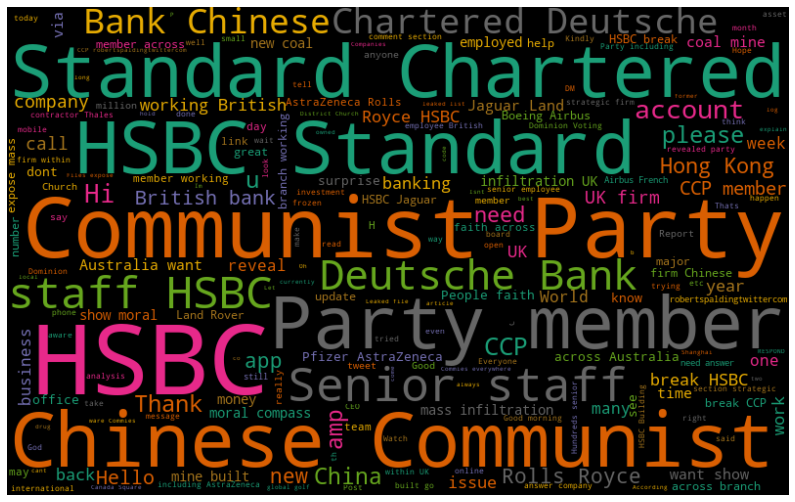

In [94]:
all_words = ' '.join([text for text in tweets_df['absolute_tidy_tweets'][tweets_df.sentiment == 'pos']])
generate_wordcloud(all_words)

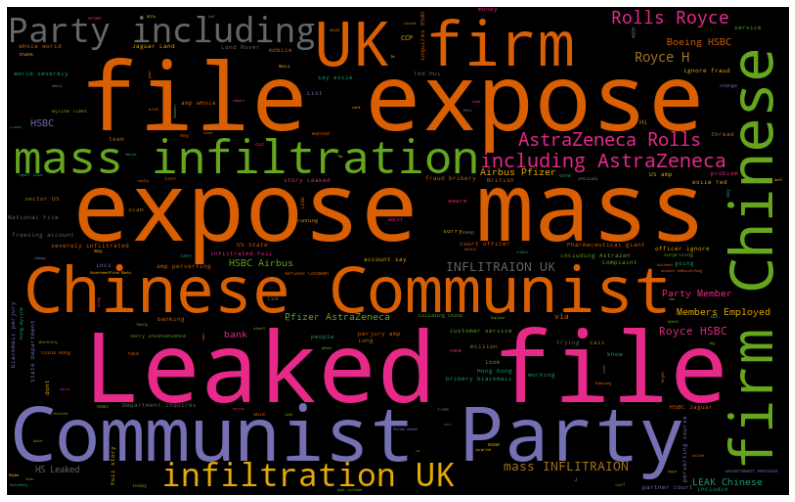

In [95]:
all_words = ' '.join([text for text in tweets_df['absolute_tidy_tweets'][tweets_df.sentiment == 'neg']])
generate_wordcloud(all_words)

In [98]:
# Most commonly used Hashtags

In [99]:
def hashtag_extract(text_list):
    hashtags = []
    # Loop over the words in the tweet
    for text in text_list:
        ht = re.findall(r"#(\w+)", text)
        hashtags.append(ht)

    return hashtags

def generate_hashtag_freqdist(hashtags):
    a = nltk.FreqDist(hashtags)
    d = pd.DataFrame({'Hashtag': list(a.keys()),
                      'Count': list(a.values())})
    # selecting top 15 most frequent hashtags     
    d = d.nlargest(columns="Count", n = 25)
    plt.figure(figsize=(16,7))
    ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
    plt.xticks(rotation=80)
    ax.set(ylabel = 'Count')
    plt.show()

In [100]:
hashtags = hashtag_extract(tweets_df['tidy_tweets'])
hashtags = sum(hashtags, [])

C:\Users\khura\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 34315 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\khura\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 26524 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\khura\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\khura\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 22577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\khura\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 34315 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\khura\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 26524 missing from cur

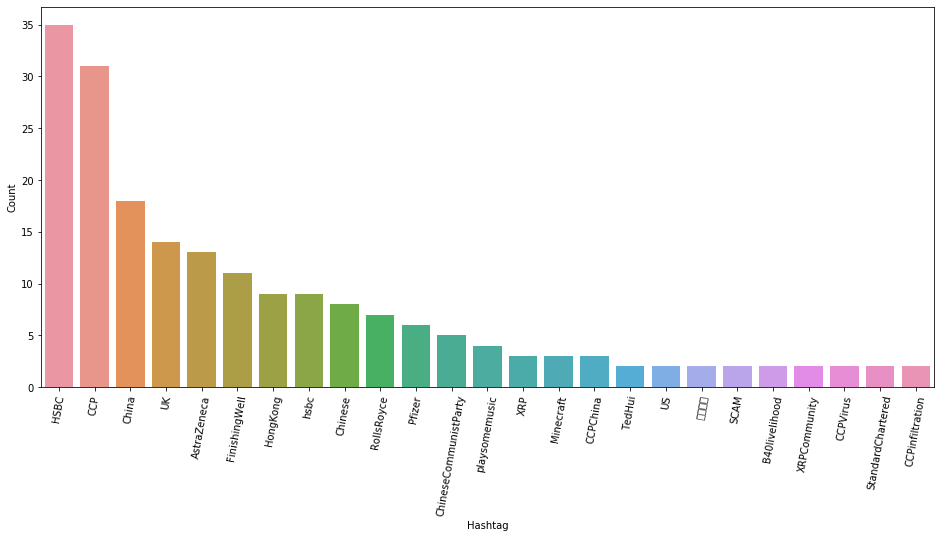

In [101]:
generate_hashtag_freqdist(hashtags)

In [102]:
# For sake of consistency, we are going to discard the records which contains no phrases i.e where tweets_df['key_phrases'] contains []
tweets_df2 = tweets_df[tweets_df['key_phrases'].str.len()>0]

In [ ]:
# Feature Extraction for 'Key Words'

In [103]:
# BOW features
bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
# bag-of-words feature matrix
bow_word_feature = bow_word_vectorizer.fit_transform(tweets_df2['absolute_tidy_tweets'])

# TF-IDF features
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
# TF-IDF feature matrix
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(tweets_df2['absolute_tidy_tweets'])

In [105]:
# Feature Extraction for 'Key Phrases'

In [106]:
phrase_sents = tweets_df2['key_phrases'].apply(lambda x: ' '.join(x))

# BOW phrase features
bow_phrase_vectorizer = CountVectorizer(max_df=0.90, min_df=2)
bow_phrase_feature = bow_phrase_vectorizer.fit_transform(phrase_sents)

# TF-IDF phrase feature
tfidf_phrase_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2)
tfidf_phrase_feature = tfidf_phrase_vectorizer.fit_transform(phrase_sents)

In [96]:
! git fetch
! git add Sentiment_Analysis_updated.ipynb
! git commit -m "New code push" Sentiment_Analysis_updated.ipynb
! git push origin

From https://github.com/Ashishkhurana01/NLP
   bbe1c19..c09d4c3  main       -> origin/main
The file will have its original line endings in your working directory


[main 2f07afa] New code push
 1 file changed, 451 insertions(+), 7 deletions(-)


The file will have its original line endings in your working directory
To https://github.com/Ashishkhurana01/NLP.git
 ! [rejected]        main -> main (non-fast-forward)
error: failed to push some refs to 'https://github.com/Ashishkhurana01/NLP.git'
hint: Updates were rejected because the tip of your current branch is behind
hint: its remote counterpart. Integrate the remote changes (e.g.
hint: 'git pull ...') before pushing again.
hint: See the 'Note about fast-forwards' in 'git push --help' for details.
